# Customer Transaction Prediction and EDA
---

 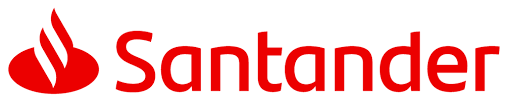

Santander published this competition to predict that the particular customer will do the transaction or not. 

- [Problem Statement](intLink)
- [Import libraries](## Import libraries)
- [Load Dataset](intLink)
- [EDA](intLink)
    - [Data Visualization](intLink)
    - [Data Prepration](intLink)
    - [Missing values](intLink)
    - [Feature Selection](intLink)
    - [Feature Correlation](intLink)
    - [Data Prepration](intLink)
- [Feature Engineering](intLink)
- [Model Training ](intLink)
- [Submission](intLink)
- [References](intLink)



### Problem Statement
---
>  This is a binary classification competition, in this competition, we need to predict that the customer will do the transaction or not. The dataset that is shared by the organizer is having numeric data fields.

### Import libraries
---

We are importing all the libraries, which will be used in our model training.  

In [ ]:
import gc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from datetime import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go

import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
%time
# Enable automatic garbage collection.
gc.enable()
#For Repreduciton the 
seed = 127
np.random.seed(seed)

### Load Dataset

In this section, We will load all the train and test dataset. Which we will use for our EDA and model training.

In [ ]:
%time
# train_df = pd.read_csv("../input/santander-customer-transaction-prediction/train.csv",nrows=3000)
# test_df = pd.read_csv("../input/santander-customer-transaction-prediction/test.csv",nrows=3000) 

train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv") 

## Exploratry Data Analysis(EDA)
EDA is the most important component of data scinece  project workflow. Before  going to model, we need to understand the data from different angles.
   
    1- Type of feature
    2- Data types of featues 
    3- Missing Values.

In [ ]:
# Show all the columns in train set
train_df.shape, train_df.columns

In [ ]:
# All features in Test set and sha
test_df.shape ,test_df.columns

- Both train and Test dataset have same number of samples 20000, but both are having different number features. Because train dataset has target feature.


> Train Set:
    * ID_code: Identifier for the transaction or customer 
    * Target: Label feature for training 
    * 202: are training features for model like var_1.... var_199
>Test Set:
    * ID_code: Identifier for the transaction or customer 
    * 202: are testing  features same as training features for model like var_1.... var_199
    
- Dataset shape/dimission
- Dataset is imblanced as class 0 has aprox 175000 sample and class 1 has near about 25000 sample. 

In [ ]:
train_df.shape, test_df.shape

#### Data type
We will check the datatype of all the feaures in both train and test. 

In [ ]:
pd.DataFrame(train_df.dtypes).transpose()

In [ ]:
pd.DataFrame(test_df.dtypes).transpose()

### Missing Values
> Analysing the missing value of features. So we can do imputaiton if any missing value present in any feature. 
> As data set is imblance, we will use cross-validation instead of traditional train test split. 

In [ ]:
def missingcount(count, samples):
        """
        :rtype: object
        """ 
        return (int(count) /samples) * 100
    
def missingPercent(df):
        """
        This Mehtod will return  mising value in respect to perticular feature
        :rtype: object|
        """ 
        count_df = pd.DataFrame(df.isnull().sum(axis=0).reset_index())
        count_df.columns = ['FEATURE', 'MISSING_COUNT']
        count_df["MISSING_%"] = count_df["MISSING_COUNT"].map(lambda x: missingcount(x, df.shape[0] ))
        return count_df.set_index('FEATURE').T

In [ ]:
# Training set
missingPercent(train_df) 

In [ ]:
# Testing 
missingPercent(test_df)

As per the above analysis, Train and Test don't have any missing value. So we don't need to perform any imputation for handling the  missing values.

Pandas describe funcation will help in getting general statistics about the dataset. Like Min, max STD and count etc.

In [ ]:
train_df.describe()

In [ ]:
train_df.describe()

This is giving more insight of data. 
    -  Standard Deviation is relatively large for both train and test set.
    -  Max, Min and STD are quite close in both train and test data set.
    -  Min is distibuted over the large number of range.


### Data Visualization 
Visualization will help us to understand distribution. It's most important part of EDA. Every thing in the world, we can understand better if we have Visualization for it.  

In [ ]:
# Calculate percentage classe
def sample_percentage_per_class(label, values, title="Target Classes Percentage"):
    trace=go.Pie(labels=label, values=values) 
    layout=go.Layout(title=title, height=600, margin=go.Margin(l=0, r=200, b=100, t=100, pad=4))   # Margins - Left, Right, Top Bottom, Padding)
    fig=go.Figure(data=[trace], layout=layout)
    iplot(fig)

In [ ]:
labels=[str(x) for x in list(train_df.target.unique())]
values=[(len(train_df[train_df.target == 0])/len(train_df))*100,(len(train_df[train_df.target > 0])/len(train_df))*100]
sample_percentage_per_class(labels,values)

This is clearly showing that we are working or we have highly imblanced dataset.

In [ ]:
sns.countplot(x='target',data=train_df)

### Histograms
A histogram is a plot that lets you discover, and show, the underlying frequency distribution.

[Histograms](https://statistics.laerd.com/statistical-guides/understanding-histograms.php)

In [ ]:
train_df.var_0.hist(bins=20)

In [ ]:
train_df.var_1.hist()

### Data Relationships
Visualizaiton of data relationship, will help us to understand the degree of correlation between features and the dependencies. 
With the help of scatterplot and heatmap we can show the relationship of features.

In [ ]:
# Compute the Correlation matrix
corr=train_df.iloc[:,:20].corr()

In [ ]:
# Set the matplotlib figure 
fig, ax=plt.subplots(figsize=(20,20))
# Generate a custom diverging colormap
Cmap=sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap
_= sns.heatmap(corr,  ax=ax, annot=True,   vmin=-1, linewidths=0.2)


### Feature Selection 
Feature selection is the process of selection the features, which are more relevent for our model and not carring unnecessary noise to final model. Also it can help in giving idea about the new feature(Drived Features).
I will use RandomForest for it, it will help us to detect the features importance.

In [ ]:
rf = RandomForestClassifier( max_depth=10, verbose=3, n_estimators=20)
parameters = {'n_estimators': [120, 100], 'max_depth':[3,5,]}
grid = GridSearchCV(rf, parameters, cv=3, n_jobs=-1, verbose=3, scoring=make_scorer(roc_auc_score))

In [ ]:
df_train_FS=train_df
grid.fit(df_train_FS.drop(["target",'ID_code'], axis=1).values, df_train_FS.target.values)

In [ ]:
grid.best_score_

 >** Showing top 10 features **

In [ ]:
n_top=10
importance_feature_df=grid.best_estimator_.feature_importances_
idx=np.argsort(importance_feature_df)[::-1][0:n_top]
features_name=df_train_FS.drop(["target",'ID_code'], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=features_name[idx], y=importance_feature_df[idx],n_boot=10)
# plt.tab

### Calculate which features are important for price prediction
Calcualte importance and show the importance of feature. 

In [ ]:
X=df_train_FS.drop(["target",'ID_code'], axis=1)
Y=df_train_FS.target

In [ ]:
x_train,x_test,y_train, y_test = train_test_split(X, Y, random_state=41)
rfmodel=RandomForestClassifier( max_depth=10, n_estimators=20,verbose=0).fit(x_train, y_train)

In [ ]:
perm = PermutationImportance(rfmodel, random_state=41, scoring=make_scorer(roc_auc_score)).fit(x_test,y_test)

In [ ]:
eli5.show_weights(perm, feature_names = x_test.columns.tolist(), top=80)

#### Check unique values of feature 
- 

In [ ]:
# ## check unique values in both train and test dataset feature
# train_df.v

### Feature Engineering 

In feature Engineering, We will create new feature and may be we can also remove some feature. 

In [ ]:
y = train_df.target
train_df= train_df.iloc[:, 2:]

In [ ]:
# Adding list of Ids to a new dataframe  for submission 
ids = test_df.ID_code.to_frame()
# Removing Id_code feature from Test data
test_df.drop('ID_code', inplace=True, axis=1)

In [ ]:
%%time
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [ ]:
test_df.shape, train_df.shape

In [ ]:
# Normalization of features
sc = StandardScaler(seed, with_std=True)
sc.fit(train_df)
train_df= sc.transform(train_df) 
test_df = sc.transform(test_df)

In [ ]:
train_df.shape,test_df.shape

In [ ]:
# List fo HyperParam for LightGBM 
params = {
    'tree_learner': 'serial',
    'objective': 'binary',
    'learning_rate': 0.00742,
    'num_leaves': 3,  # Lower value for better accuracy
    'bagging_freq': 5,
    'bagging_fraction': 0.33,
    'boost_from_average':True,
    'boost': 'gbrt',
    'feature_fraction': 0.04,    
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 85,
    'min_sum_hessian_in_leaf': 0.80,
    'num_threads': 16,
    'verbosity': 1
}

In [ ]:
num_round = 250000
# Cross-validation
folds = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
lstCV=folds.split(train_df, y)

In [ ]:
# Train and Test Predication Vector
train_pred = np.zeros(len(train_df))
test_pred = np.zeros(len(test_df))

In [ ]:
%time
for fold_, (trn_idx, val_idx) in enumerate(lstCV):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df[trn_idx], label=y[trn_idx])
    val_data = lgb.Dataset(train_df[val_idx], label=y[val_idx])
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3500)
    train_pred[val_idx] = clf.predict(train_df[val_idx], num_iteration=clf.best_iteration)
    test_pred += clf.predict(test_df, num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(y, train_pred)))

In [ ]:
sub_df = pd.DataFrame({"ID_code": ids["ID_code"]})
sub_df["target"] = test_pred
sub_df.to_csv("submission.csv", index=False)